In [1]:
from os import path, listdir
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
from TROPOMI import S5P_Filename
import geopandas as gpd

/home/users/mwlw3/miniconda3/envs/AQmort/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [164]:
folderpath = "/neodc/sentinel5p/data/L2_NO2/v2.2/2021/11/05/"

In [151]:
# listdir(folderpath)

In [165]:
files = []

for file in listdir(folderpath):
    file = S5P_Filename(file)
    if file.extension == ".nc":
        files.append(path.join(folderpath, file.filename))
print(len(files))

174


Open and plot the data from one netCDF file:

In [166]:
ds = xr.open_dataset(files[0], group="PRODUCT")
print(ds.dims)

Frozen({'scanline': 285, 'ground_pixel': 450, 'time': 1, 'corner': 4, 'polynomial_exponents': 6, 'intensity_offset_polynomial_exponents': 1, 'layer': 34, 'vertices': 2})


In [167]:
ds.nitrogendioxide_tropospheric_column.attrs

{'units': 'mol m-2',
 'standard_name': 'troposphere_mole_content_of_nitrogen_dioxide',
 'long_name': 'Tropospheric vertical column of nitrogen dioxide',
 'ancillary_variables': 'nitrogendioxide_tropospheric_column_precision air_mass_factor_troposphere air_mass_factor_total averaging_kernel',
 'multiplication_factor_to_convert_to_molecules_percm2': 6.02214e+19}

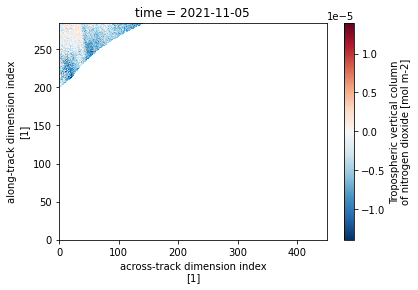

In [168]:
ds.nitrogendioxide_tropospheric_column.plot()
plt.show()

This uses the along-track and across-track dimensions of the satellite path. I want to plot on a global map... Make a new dataarray?

In [169]:
da = xr.DataArray(
    ds.nitrogendioxide_tropospheric_column.values[0,:,:],
    coords={
        "longitude": (["x", "y"], ds.longitude.values[0,:,:]),
        "latitude": (["x", "y"], ds.latitude.values[0,:,:])},
    dims=["x", "y"]
)

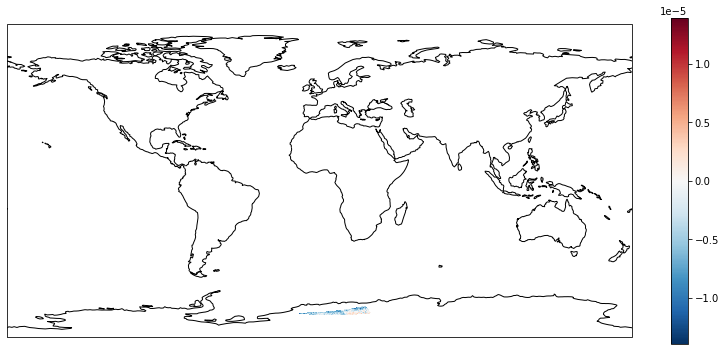

In [170]:
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
da.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude", add_colorbar=True, shading="auto"
)
ax.coastlines()
plt.show()

In [171]:
np.isnan(da.values).sum()

123192

Let me try to combine all the data from the specified date, so I can see a broader spatial region.

In [172]:
dataarrays = []

for i in tqdm(range(len(files))):
    ds = xr.open_dataset(files[i], group="PRODUCT")

    da = xr.DataArray(
        ds.nitrogendioxide_tropospheric_column.values[0,:,:],
        coords={
            "longitude": (["x", "y"], ds.longitude.values[0,:,:]),
            "latitude": (["x", "y"], ds.latitude.values[0,:,:])},
        dims=["x", "y"])
    
    dataarrays.append(da)

100%|██████████| 174/174 [01:45<00:00,  1.65it/s]


In [173]:
# new_ds = xr.concat(dataarrays, dim="x") # I don't think I know what I'm doing...

100%|██████████| 174/174 [00:34<00:00,  5.01it/s]


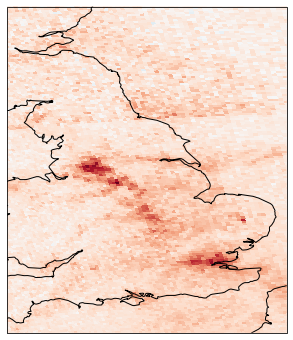

In [181]:
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
for i in tqdm(range(len(dataarrays))): # What if I just plot them all together?
    dataarrays[i].plot.pcolormesh(
        ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude", cmap="RdBu_r", add_colorbar=False, shading="auto")
ax.coastlines()
plt.xlim((-4, 2))
plt.ylim((50, 57))
plt.show()